In [226]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

#from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
#from ignite.metrics import Loss
#from ignite.metrics import MeanSquaredError

#device = torch.device("cpu")
#print(torch.cuda.is_available())
device = torch.device("cuda")

Load prepared data

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms

def use_gpu(array):
    return torch.from_numpy(array).float().cuda()


class geneticData(Dataset):
    def __init__(self, source, transform=None):
        self.data = np.load(source, allow_pickle = True)
        self.x = self.data['hist_counts'].T
        self.y = self.data['targets'][0]
        assert self.x.shape[0] == self.y.shape[0], 'sizes screwy'
        self.x_means = np.mean(self.x, axis=0)
        self.x_std=np.std(self.x, axis=0)

    def __getitem__(self, idx):
        return use_gpu(self.x[idx, :]), use_gpu(self.y[idx].reshape(-1))
    
    def __len__(self):
        return self.y.shape[0]

    

In [ ]:
def n_by_ps(total, ps):
    #return total percentages as numbers
    assert np.isclose(sum(ps), 1), 'ps sum to 1'
    ns = np.floor(total * np.array(ps))
    ns[0] += total - sum(ns)
    return ns.astype(int).tolist()
    
n_by_ps(101, [.7,.2,.1])

In [ ]:
data_path = 'data_COAD_STAD_w1e6.npz'
full = geneticData(data_path)
train, val, test = random_split(full, n_by_ps(len(full), [.70, .15, .15]))

n_features = full.x.shape[1]
batch_size=200
p = 0
torch.manual_seed(2515)
print(n_features, " features, ", len(full), " samples")

Note zero-inflation

Transforming the target variable is useful for training, then can un-transform at prediction time.   
https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/  
https://stats.stackexchange.com/questions/306630/network-architecture-to-predict-zero-inflated-output  
https://stats.stackexchange.com/questions/230765/regression-with-zero-inflated-continuous-response-variable-using-gradient-boosti  
https://stats.stackexchange.com/questions/157438/what-is-the-best-data-transformation-for-absolute-zero-inflated-distributions  
https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203  

In [ ]:
full.x[3,:].shape

In [ ]:
pd.DataFrame(np.array(full.y)).hist()

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle =True, num_workers = p)
val_loader = DataLoader(val, batch_size=len(val), shuffle=False, num_workers = p)
test_loader = DataLoader(test, batch_size=len(test), shuffle=False, num_workers = p)

In [ ]:
for x,y in val_loader:
    print(x.shape,y.shape)

Define model

In [259]:
H1 = 50
H2 = 100
H3 = 50

model = nn.Sequential(
    torch.nn.BatchNorm1d(n_features), 
    nn.Linear(n_features, H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.ReLU(),
    #nn.Dropout(p=0.2),
    nn.Linear(H3, 1),
    #nn.Softplus(),
    #nn.Sigmoid()
).to(device)
#model = model.cuda()
opt = torch.optim.SGD(model.parameters(), lr=1e-2)#, momentum=0)
criterion = nn.L1Loss() 

In [261]:
model.train()
epochs = 100

for epoch in range(epochs): 
    epoch_loss = []
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss.append(loss)
        #print('train loss: ', loss)
    print('epoch loss: ', sum(epoch_loss))

epoch loss:  tensor(218.4138, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(229.5119, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(215.3684, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(222.2890, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(209.2064, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(218.0925, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(229.0090, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(213.1785, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(226.5756, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(225.3607, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(211.0328, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(218.5381, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(232.0074, device='cuda:0', grad_fn=<AddBackward0>)
epoch loss:  tensor(216.0428, device='cuda:0', grad_fn=<AddBackward0>)
epoch 

In [262]:
model

Sequential(
  (0): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=34, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=100, bias=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ReLU()
  (13): Linear(in_features=100, out_features=50, bias=True)
  (14): ReLU()
  (15): Linear(in_features=50, out_features=1, bias=True)
)

False
[ 0.71728825 14.18829672]  
0.7173 x + 14.19


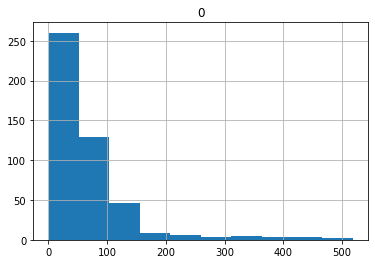

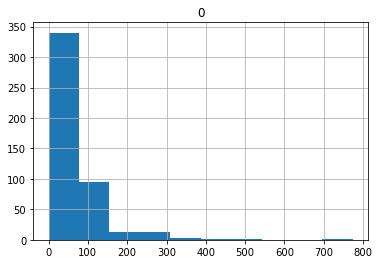

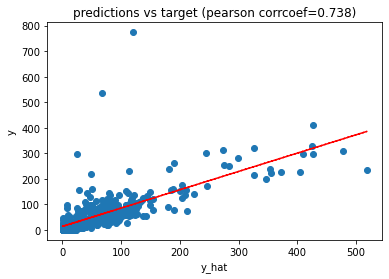

In [298]:
# scatter prediciton success
import matplotlib.pyplot as plt
model.eval()

for X, y in val_loader:
    y_hat = model(X).cpu().detach().numpy().flatten()
    y = y.cpu().detach().numpy().flatten()
    print(all(y_hat == 0))
    hist(y_hat)
    hist(y)
    #res = pd.DataFrame.from_dict({'y_hat': y_hat, 'y': y})

fig, ax = plt.subplots()
    
pf = np.polyfit(y_hat, y, 1)
p = np.poly1d(pf)
c = round(np.corrcoef(y_hat, y)[0,1], 3)

ax.plot(y_hat, y, 'o')
ax.plot(y_hat, p(y_hat),"r--")

ax.set_title(f'predictions vs target (pearson corrcoef={c})')
ax.set_xlabel('y_hat')
ax.set_ylabel('y')

print(pf, p)

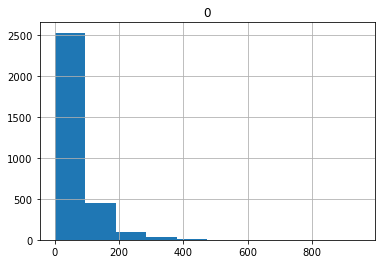

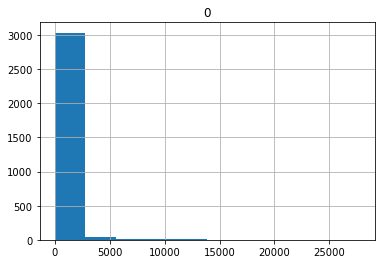

In [273]:
def hist(x):
    pd.DataFrame(x).hist()
    
hist(a['targets'][0])
hist(a['hist_counts'][3])

In [195]:
a['hist_counts'][0:5].shape

(5, 3119)

https://captum.ai/tutorials/House_Prices_Regression_Interpret

In [120]:

a = np.load('data_COAD_STAD_w1e6.npz')
feature_names = []
corrcoefs = []
for i in range(a['hist_counts'].shape[0]):
    corrcoefs.append(round(np.corrcoef(a['hist_counts'][i,:], a['targets'][0])[1,0], 3))
    feature_names.append("feature " + str(i))

    
a['targets'][0][a['targets'][0] != 0].shape

(2584,)

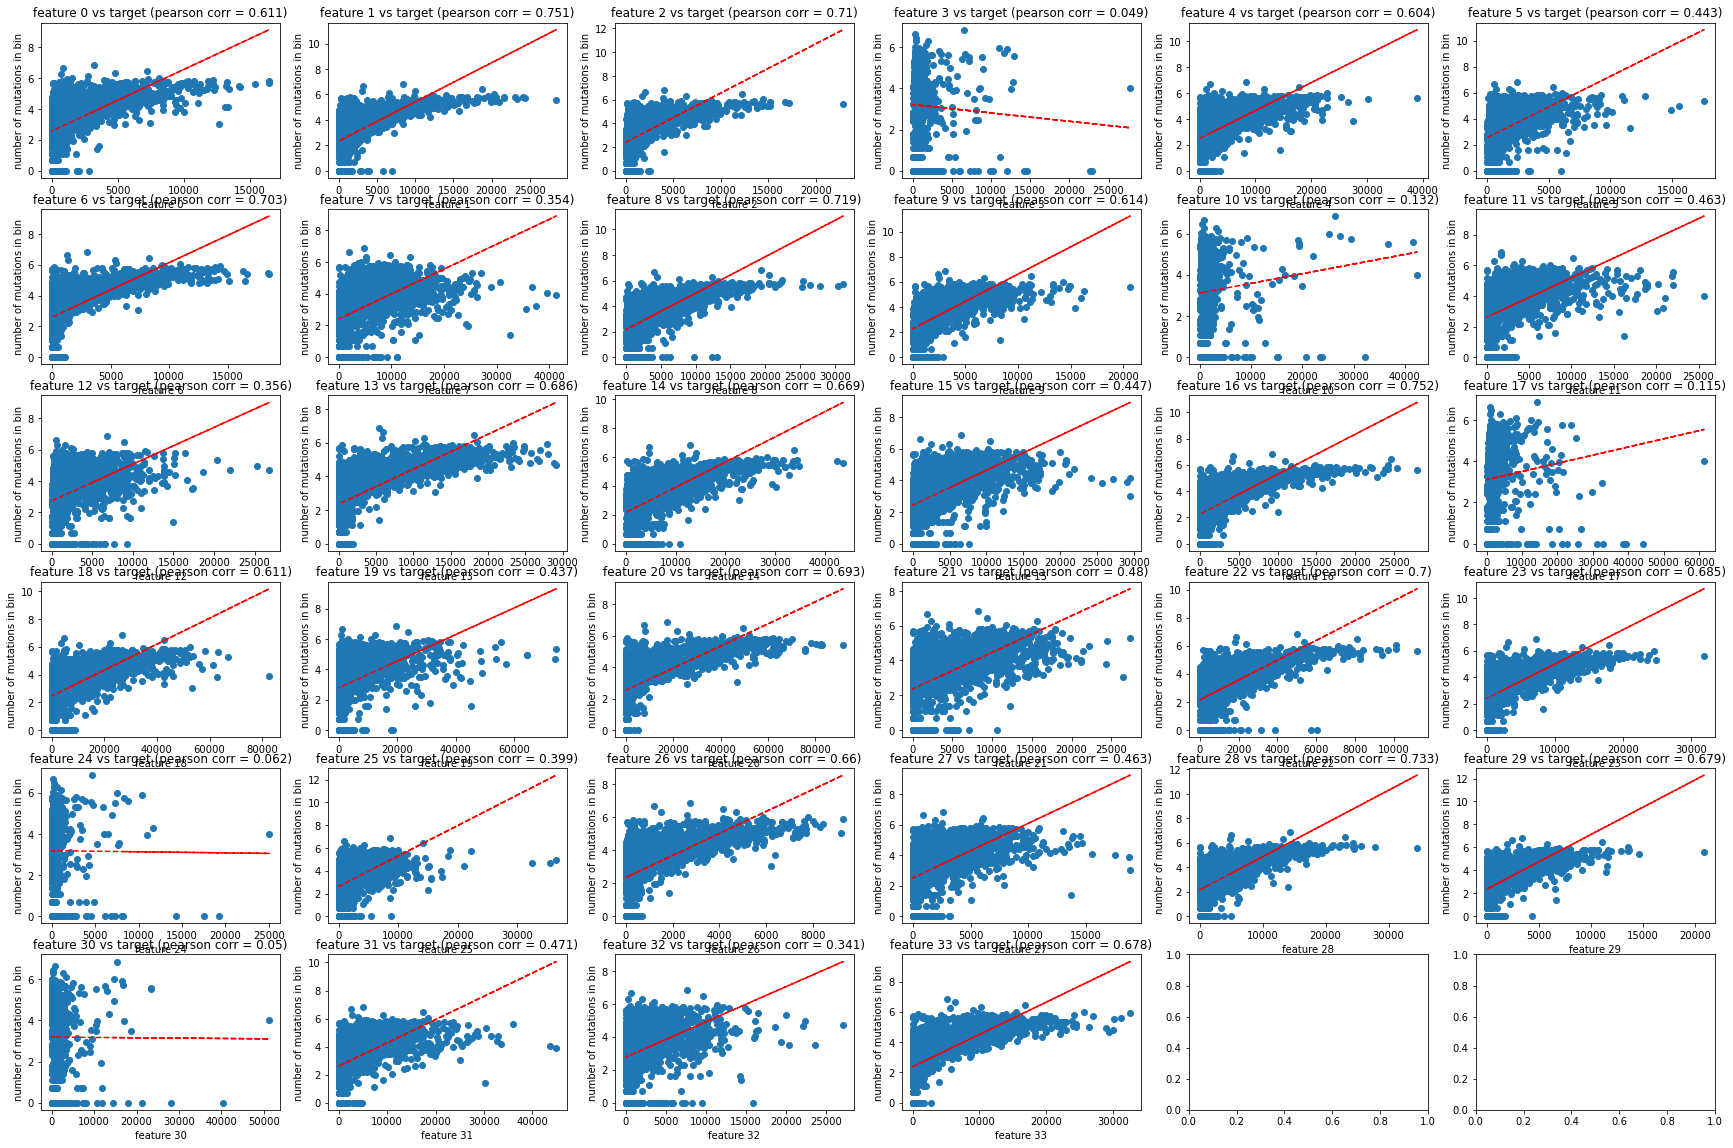

In [121]:
import matplotlib.pyplot as plt

X = a['hist_counts'].T[a['targets'][0] != 0]
y = a['targets'][0][a['targets'][0] != 0]

X = a['hist_counts'].T
y = np.log(1 + a['targets'][0])

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(30, 20))
for i, (ax, col, corr) in enumerate(zip(axs.flat, feature_names, corrcoefs)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs target (pearson corr = ' + str(corr) + ')')
    ax.set_xlabel(col)
    ax.set_ylabel('number of mutations in bin')


I selected 12 features of the higest predicting histone marks



```
a = np.load('data12.npz')
feature_names = []
corrcoefs = []
for i in range(a['hist_counts'].shape[0]):
    corrcoefs.append(round(np.corrcoef(a['hist_counts'][i,:], a['targets'][0])[1,0], 3))
    feature_names.append("feature " + str(i))
    
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 3, ncols=4, figsize=(30, 20))
for i, (ax, col, corr) in enumerate(zip(axs.flat, feature_names, corrcoefs)):
    x = a['hist_counts'].T[:,i]
    y = a['targets'][0]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs target (pearson corr = ' + str(corr) + ')')
    ax.set_xlabel(col)
    ax.set_ylabel('number of mutations in bin')
```

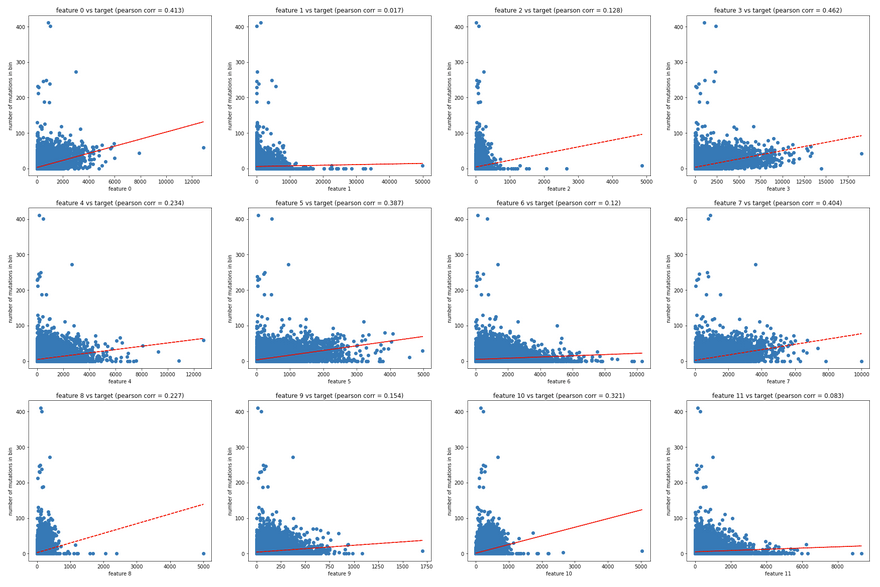

Prediction was terrible! Then I realized that the consolidated epigenomes that I chose from were not specific to the cancers

(tensor([ 131.,  561.,   48.,   96.,  395.,   26., 1194.,  208.,   67.,   84.,
          146., 1041.], device='cuda:0'),
 tensor(0., device='cuda:0'))

Train

In [140]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, RootMeanSquaredError, Loss, Average, MeanSquaredError, MeanPairwiseDistance

trainer = create_supervised_trainer(model, optimizer, criterion)

val_metrics = {
    "M1": MeanSquaredError(),
    "M2": Loss(nn.L1Loss())
}

evaluator = create_supervised_evaluator(model, metrics=val_metrics)

# logging goes here
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(trainer):
    print("Epoch[{}] Loss: {:.2f}".format(trainer.state.epoch, trainer.state.output))

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics["M1"], metrics["M2"]))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics["M1"], metrics["M2"]))


In [141]:
trainer.run(train_loader, max_epochs=10)

Epoch[1] Loss: 5.46
Epoch[1] Loss: 7.49
Training Results - Epoch: 1  Avg accuracy: 165.99 Avg loss: 5.79
Validation Results - Epoch: 1  Avg accuracy: 140.76 Avg loss: 5.71
Epoch[2] Loss: 6.56
Epoch[2] Loss: 5.37
Training Results - Epoch: 2  Avg accuracy: 165.99 Avg loss: 5.79
Validation Results - Epoch: 2  Avg accuracy: 140.76 Avg loss: 5.71
Epoch[3] Loss: 7.78
Epoch[3] Loss: 5.68
Training Results - Epoch: 3  Avg accuracy: 165.99 Avg loss: 5.79
Validation Results - Epoch: 3  Avg accuracy: 140.76 Avg loss: 5.71
Epoch[4] Loss: 6.11
Epoch[4] Loss: 5.63
Training Results - Epoch: 4  Avg accuracy: 165.99 Avg loss: 5.79
Validation Results - Epoch: 4  Avg accuracy: 140.76 Avg loss: 5.71
Epoch[5] Loss: 8.99
Epoch[5] Loss: 7.29
Training Results - Epoch: 5  Avg accuracy: 165.99 Avg loss: 5.79
Validation Results - Epoch: 5  Avg accuracy: 140.76 Avg loss: 5.71
Epoch[6] Loss: 4.99
Epoch[6] Loss: 6.61
Epoch[6] Loss: 6.16
Training Results - Epoch: 6  Avg accuracy: 165.99 Avg loss: 5.79
Validation Resu

State:
	iteration: 2170
	epoch: 10
	epoch_length: 217
	max_epochs: 10
	output: 5.081395149230957
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
model

In [66]:
class Feedforward(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = nn.Linear(self.input_size, self.hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(self.hidden_size, 1)
            self.sigmoid = nn.Sigmoid()        
        
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

model = Feedforward(n_features, 50)
criterion = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr = 0.01)



TypeError: 'generator' object is not subscriptable

In [153]:
for param in model.parameters():
  print(param.data)

tensor([[-0.5285, -0.5012],
        [ 0.1991, -0.0900],
        [ 0.3047,  0.2053],
        [ 0.3834,  0.0214],
        [-0.2300, -0.0504],
        [-0.6143,  0.7699],
        [ 0.4820, -0.0673],
        [-0.5795, -0.2488],
        [-0.6292, -0.0752],
        [-0.6127, -0.0897],
        [-0.4500,  0.4597],
        [ 0.0566, -0.2859],
        [-0.1582, -0.6636],
        [ 0.4641,  0.0275],
        [-0.6876, -0.5248],
        [-0.0675,  0.5594],
        [-0.1067, -0.2442],
        [-0.2170,  0.7731],
        [ 0.3783, -0.0505],
        [-0.3139, -0.4351],
        [ 0.5615, -0.2382],
        [-0.0106,  0.6140],
        [ 0.3913,  0.1624],
        [-0.0874,  0.1473],
        [-0.6591,  0.3774],
        [ 0.3752,  0.4593],
        [ 0.6134,  0.4309],
        [-0.6795, -0.5692],
        [ 0.0873, -0.4256],
        [ 0.3381, -0.5028],
        [ 0.5472, -0.1819],
        [ 0.4318,  0.3688],
        [ 0.4236,  0.0083],
        [ 0.6225, -0.1692],
        [ 0.3004,  0.6468],
        [ 0.2453,  0

Test

In [154]:
model.eval()
y_pred = model(x_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

NameError: name 'x_test' is not defined